In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import scipy

%matplotlib inline
from matplotlib import pyplot as plt

In [4]:

train_df = pd.read_csv('howpop_train.csv')
test_df  = pd.read_csv('howpop_test.csv')

In [5]:
train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


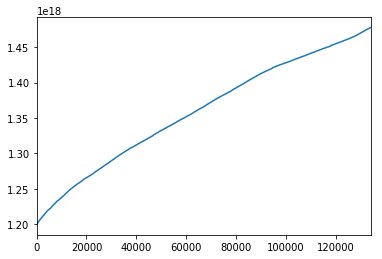

In [6]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

In [27]:
train_df.corr()

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


In [28]:
print(train_df.published.dtype)
train_df['published'] = pd.to_datetime(train_df.published, yearfirst = True)
print(train_df.published.dtype)

object
datetime64[ns]


In [29]:
train_df['year'] = [d.year for d in train_df.published]
train_df['month'] = [d.month for d in train_df.published]
train_df['day'] = [d.day for d in train_df.published]

train_df['dayofweek'] = [d.isoweekday() for d in train_df.published]
train_df['hour'] = [d.hour for d in train_df.published]

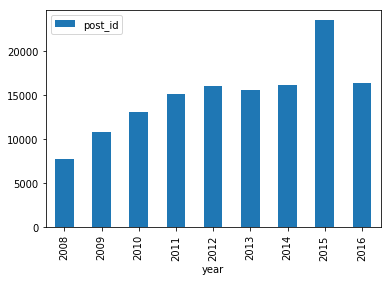

In [30]:
train_df.groupby(['year'])[['post_id']].count().plot(kind='bar')

In [31]:
train_df.shape

(134137, 22)

In [32]:
train_df[train_df["year"] == 2015]['post_id'].count()

23452

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
vectorizer = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))
X = vectorizer.fit_transform(train_df['title'])

In [44]:
X.shape

(134137, 75378)

In [70]:
vectorizer.vocabulary_['python']

KeyError: 'python'

In [54]:
vectorizer = TfidfVectorizer(analyzer='char')
X = vectorizer.fit_transform(train_df['title'])

In [55]:
X.shape

(134137, 235)

In [57]:
from sklearn.feature_extraction import DictVectorizer

In [58]:
vectorizer = DictVectorizer()

In [64]:
X_train = train_df
feats = ['author', 'flow', 'domain']
X_train[feats][:5]
X_train[feats][:5].fillna('-')
X_train[feats][:5].fillna('-').T.to_dict()
X_train[feats][:5].fillna('-').T.to_dict().values()

for col in feats:
    print(col,len(X_train[col][:5].fillna('-').unique()))

author 4
flow 3
domain 2


In [67]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])
len(train_df), train_size

X, y = train_df.loc[:, features],  train_df['favs_lognorm'] #отделяем признаки от целевой переменной
X_test = test_df.loc[:, features]
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

vectorizer_feats = DictVectorizer()

X_train_feats = vectorizer_feats.fit_transform(X_train[feats])
#X_valid_feats = vectorizer_feats.transform(X_valid[feats])
#X_test_feats = vectorizer_feats.transform(X_test[feats])

AttributeError: 'str' object has no attribute 'items'